In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
#import tensorflow as tf
import matplotlib.pyplot as plt
import os

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
#tf.random.set_seed(7)

In [2]:
train = pd.read_csv('../input/train.csv', index_col = 'id')
test = pd.read_csv('../input/test.csv', index_col = 'id')
print(train.shape)
print(train.head(10))
print(test.shape)
print(test.head(10))

(4752, 59)
    X00    X01  X02  X03  X04     X05    X06   X07     X08     X09  ...  Y09  \
id                                                                  ...        
0   9.7  988.8  1.2  0.6  0.0  1009.3  989.6  12.2  1009.9  1009.8  ...  7.0   
1   9.3  988.9  1.7  1.9  0.0  1009.3  989.6  12.1  1010.0  1009.9  ...  6.5   
2   9.4  989.0  1.1  2.3  0.0  1009.2  989.7  12.1  1010.1  1010.1  ...  6.5   
3   9.4  988.9  1.5  0.7  0.0  1009.2  989.6  12.0  1010.0  1010.0  ...  6.0   
4   9.2  988.9  0.8  1.7  0.0  1009.2  989.7  12.0  1010.1  1010.0  ...  6.0   
5   9.1  988.9  1.3  0.7  0.0  1009.1  989.6  12.0  1010.0  1010.0  ...  6.0   
6   9.1  988.8  2.4  1.9  0.0  1009.1  989.6  12.0  1010.1  1010.0  ...  5.5   
7   8.9  988.9  1.0  1.2  0.0  1009.2  989.7  11.9  1010.1  1010.1  ...  5.5   
8   9.0  988.9  1.5  0.1  0.0  1009.2  989.6  11.9  1010.0  1010.1  ...  5.0   
9   8.8  988.9  1.4  0.4  0.0  1009.4  989.6  11.8  1010.1  1010.1  ...  4.5   

    Y10  Y11  Y12   Y13  Y14

In [3]:
# 기온           X00, X07, X28, X31, X32
# 현지기압        X01, X06, X22, X27, X29
# 풍속           X02, X03, X18, X24, X26
# 일일누적강수량   X04, X10, X21, X36, X39
# 해면기압        X05, X08, X09, X23, X33
# 일일누적일사량   X11, X14, X16, X19, X34
# 습도           X12, X20, X30, X37, X38
# 풍향           X13, X15, X17, X25, X35

In [4]:

def train_gen1(data, col): # train, 'Y00'

    df = data[['X00', 'X07', 'X28', 'X31', 'X32']]
    df['day'] = df.index // 144
    df['hour'] = (df.index  - (df.day * 144)) // 6
    df = df[['day', 'hour', 'X00', 'X07', 'X28', 'X31', 'X32']]
    df['tmp'] = data[[col]]
    
    
    # 하루 평균 feature
    for col_tmp in ['X00', 'X07', 'X28', 'X31', 'X32']:
        for c in ['day']:
            d = {}
            d['mean'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].mean()
            d['max'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].max()
            d['min'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].min()
            d['std'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].std()
            d['range'+c+'_'+col_tmp] = d['max'+c+'_'+col_tmp] - d['min'+c+'_'+col_tmp]
            for v in d:
                df[v] = df[c].map(d[v].to_dict())

        # add shifts
        # 10분 전, 후
        df['tmp_shift_+1_'+c+'_'+col_tmp] = [0,] + list(df[col_tmp].values[:-1])
        df['tmp_shift_-1_'+c+'_'+col_tmp] = list(df[col_tmp].values[1:]) + [0]
        
        # minus tmp
        #for c in [c1 for c1 in df.columns if c1 not in ['day', 'hour', col_tmp]]:
        #    df[c+'_mtmp'+'_'+col_tmp] = df[c] - df[col_tmp]

        
    df_30 = df[df['day']<30]

    #for c in []
    #    # None 값 채우기
    #    df_30['tmp_shift_-1_'+c].iloc[-1] = df_30['tmp_shift_-1'].iloc[-2]
    #    df_30['tmp_shift_-1_mtmp'].iloc[-1] = df_30['tmp_shift_-1_mtmp'].iloc[-2]

    print(np.sum(np.sum(df_30.isnull())))
    return df_30

In [5]:
def train_gen2(data): # train, 'Y00'

    df = data[['X00', 'X07', 'X28', 'X31', 'X32']]
    df['day'] = df.index // 144
    df['hour'] = (df.index  - (df.day * 144)) // 6
    df = df[['day', 'hour', 'X00', 'X07', 'X28', 'X31', 'X32']]
    #df['tmp'] = data[[col]]
    
    
    # 하루 평균 feature
    for col_tmp in ['X00', 'X07', 'X28', 'X31', 'X32']:
        for c in ['day']:
            d = {}
            d['mean'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].mean()
            d['max'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].max()
            d['min'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].min()
            d['std'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].std()
            d['range'+c+'_'+col_tmp] = d['max'+c+'_'+col_tmp] - d['min'+c+'_'+col_tmp]
            for v in d:
                df[v] = df[c].map(d[v].to_dict())

        # add shifts
        # 10분 전, 후
        df['tmp_shift_+1_'+c+'_'+col_tmp] = [0,] + list(df[col_tmp].values[:-1])
        df['tmp_shift_-1_'+c+'_'+col_tmp] = list(df[col_tmp].values[1:]) + [0]
        
    df_3 = df[df['day']>=30]

    print(np.sum(np.sum(df_3.isnull())))
    return df_3

In [30]:
def test_gen1(data): # train, 'Y00'

    df = data[['X00', 'X07', 'X28', 'X31', 'X32']]
    df['day'] = df.index // 144
    df['hour'] = (df.index  - (df.day * 144)) // 6
    df = df[['day', 'hour', 'X00', 'X07', 'X28', 'X31', 'X32']]
    #df['tmp'] = data[[col]]
    
    
    # 하루 평균 feature
    for col_tmp in ['X00', 'X07', 'X28', 'X31', 'X32']:
        for c in ['day']:
            d = {}
            d['mean'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].mean()
            d['max'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].max()
            d['min'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].min()
            d['std'+c+'_'+col_tmp] = df.groupby([c])[col_tmp].std()
            d['range'+c+'_'+col_tmp] = d['max'+c+'_'+col_tmp] - d['min'+c+'_'+col_tmp]
            for v in d:
                df[v] = df[c].map(d[v].to_dict())

        # add shifts
        # 10분 전, 후
        df['tmp_shift_+1_'+c+'_'+col_tmp] = [0,] + list(df[col_tmp].values[:-1])
        df['tmp_shift_-1_'+c+'_'+col_tmp] = list(df[col_tmp].values[1:]) + [0]
        
        # minus tmp
        #for c in [c1 for c1 in df.columns if c1 not in ['day', 'hour', col_tmp]]:
        #    df[c+'_mtmp'+'_'+col_tmp] = df[c] - df[col_tmp]

        
    #df_30 = df[df['day']<30]

    #for c in []
    #    # None 값 채우기
    #    df_30['tmp_shift_-1_'+c].iloc[-1] = df_30['tmp_shift_-1'].iloc[-2]
    #    df_30['tmp_shift_-1_mtmp'].iloc[-1] = df_30['tmp_shift_-1_mtmp'].iloc[-2]

    print(np.sum(np.sum(df.isnull())))
    return df

In [31]:
# Train 시작

In [32]:
import numpy as np 
import pandas as pd
from sklearn import *
import lightgbm as lgb

In [33]:
# col = [c for c in train.columns if c not in ['day', 'hour', 'tmp']]
# x1, x2, y1, y2 = model_selection.train_test_split(train[col], train['tmp'], test_size=0.3, random_state=7)
# #del train

# def lgb_Metric(preds, dtrain):
#     labels = dtrain.get_label()
#     #preds = np.round(np.clip(preds, 0, 10)).astype(int)
#     score = metrics.mean_squared_error(labels, preds)
#     return ('KaggleMetric', score, True)

# params = {'learning_rate': 0.02, 'max_depth': 7, 'num_leaves':2**7+1, 'metric':{'l2'} , 'random_state': 7, 'n_jobs':-1} 
# model = lgb.train(params, lgb.Dataset(x1, y1), 2000,  lgb.Dataset(x2, y2), verbose_eval=50, early_stopping_rounds=50)#, feval=lgb_Metric)
# #preds = model.predict(test[col], num_iteration=model.best_iteration)
# #test['open_channels'] = np.round(np.clip(preds, 0, 10)).astype(int)

# #test[['time','open_channels']].to_csv('submission.csv', index=False, float_format='%.4f')

In [34]:
train_df = train_gen1(train, 'Y00')
train_df2 = train_gen2(train)
test_df = test_gen1(test)

col = [c for c in train_df.columns if c not in ['day', 'hour', 'tmp']]

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0
0
0


In [35]:
train_df

,day,hour,X00,X07,X28,X31,X32,tmp,meanday_X00,maxday_X00,...,rangeday_X31,tmp_shift_+1_day_X31,tmp_shift_-1_day_X31,meanday_X32,maxday_X32,minday_X32,stdday_X32,rangeday_X32,tmp_shift_+1_day_X32,tmp_shift_-1_day_X32
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,9.7,12.2,12.3,8.2,10.7,12.5,15.938194,24.3,...,18.8,0.0,8.3,15.740972,23.5,5.5,6.064806,18.0,0.0,10.3
1,0,0,9.3,12.1,12.1,8.3,10.3,12.5,15.938194,24.3,...,18.8,8.2,8.0,15.740972,23.5,5.5,6.064806,18.0,10.7,9.7
2,0,0,9.4,12.1,12.1,8.0,9.7,12.0,15.938194,24.3,...,18.8,8.3,7.7,15.740972,23.5,5.5,6.064806,18.0,10.3,9.4
3,0,0,9.4,12.0,12.1,7.7,9.4,12.0,15.938194,24.3,...,18.8,8.0,7.4,15.740972,23.5,5.5,6.064806,18.0,9.7,9.4
4,0,0,9.2,12.0,12.0,7.4,9.4,12.0,15.938194,24.3,...,18.8,7.7,7.3,15.740972,23.5,5.5,6.064806,18.0,9.4,9.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,29,23,19.5,21.3,21.6,18.8,19.4,22.0,22.176389,26.9,...,9.2,18.8,18.6,21.234722,26.8,17.7,3.087972,9.1,19.5,18.5
4316,29,23,19.3,21.3,21.6,18.6,18.5,22.0,22.176389,26.9,...,9.2,18.8,18.4,21.234722,26.8,17.7,3.087972,9.1,19.4,19.1
4317,29,23,19.5,21.2,21.5,18.4,19.1,21.5,22.176389,26.9,...,9.2,18.6,18.2,21.234722,26.8,17.7,3.087972,9.1,18.5,19.0


In [85]:
model

In [86]:
train_df

,day,hour,X00,X07,X28,X31,X32,tmp,meanday_X00,maxday_X00,...,rangeday_X31,tmp_shift_+1_day_X31,tmp_shift_-1_day_X31,meanday_X32,maxday_X32,minday_X32,stdday_X32,rangeday_X32,tmp_shift_+1_day_X32,tmp_shift_-1_day_X32
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,9.7,12.2,12.3,8.2,10.7,10.5,15.938194,24.3,...,18.8,0.0,8.3,15.740972,23.5,5.5,6.064806,18.0,0.0,10.3
1,0,0,9.3,12.1,12.1,8.3,10.3,10.0,15.938194,24.3,...,18.8,8.2,8.0,15.740972,23.5,5.5,6.064806,18.0,10.7,9.7
2,0,0,9.4,12.1,12.1,8.0,9.7,10.0,15.938194,24.3,...,18.8,8.3,7.7,15.740972,23.5,5.5,6.064806,18.0,10.3,9.4
3,0,0,9.4,12.0,12.1,7.7,9.4,9.5,15.938194,24.3,...,18.8,8.0,7.4,15.740972,23.5,5.5,6.064806,18.0,9.7,9.4
4,0,0,9.2,12.0,12.0,7.4,9.4,9.5,15.938194,24.3,...,18.8,7.7,7.3,15.740972,23.5,5.5,6.064806,18.0,9.4,9.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,29,23,19.5,21.3,21.6,18.8,19.4,20.5,22.176389,26.9,...,9.2,18.8,18.6,21.234722,26.8,17.7,3.087972,9.1,19.5,18.5
4316,29,23,19.3,21.3,21.6,18.6,18.5,20.5,22.176389,26.9,...,9.2,18.8,18.4,21.234722,26.8,17.7,3.087972,9.1,19.4,19.1
4317,29,23,19.5,21.2,21.5,18.4,19.1,20.5,22.176389,26.9,...,9.2,18.6,18.2,21.234722,26.8,17.7,3.087972,9.1,18.5,19.0


In [ ]:
import sklearn


In [104]:
# result
result = []
location_list = []

prediction = []
prediction_error = []
length = train_df.shape[0]


# idx_pair
idx_pair = [(0, int(length*(1/5))), (int(length*(1/5)), int(length*(2/5))), (int(length*(2/5)), int(length*(3/5))) \
, (int(length*(3/5)), int(length*(4/5))), (int(length*(4/5)), int(length))]

for location in ['Y00','Y01','Y02','Y03','Y04','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17']:
    print("location")
    print(location)
    
    #preprocess
    train_df = train_gen1(train, location)
    length = train_df[col].shape[0]

    # columns
    col = [c for c in train_df.columns if c not in ['day', 'hour', 'tmp']]
    mse_list = []
    
    for i in range(5):
        pair = idx_pair[i]
        x1, y1 = pd.concat([train_df[col][:pair[0]],train_df[col][pair[1]:]],axis=0), pd.concat([train_df['tmp'][:pair[0]],train_df['tmp'][pair[1]:]],axis=0)
        x2, y2 = train_df[col][pair[0]:pair[1]], train_df['tmp'][pair[0]:pair[1]]

        # x1, y1 = train[col].iloc[:int(length*0.7),:], train['tmp'][:int(length*0.7)]
        # x2, y2 = train[col].iloc[int(length*0.7):,:], train['tmp'][int(length*0.7):]

        # def lgb_Metric(preds, dtrain):
        #     labels = dtrain.get_label()
        #     #preds = np.round(np.clip(preds, 0, 10)).astype(int)
        #     score = metrics.mean_squared_error(labels, preds)
        #     return ('KaggleMetric', score, True)

        params = {'learning_rate': 0.01, 'max_depth': 7, 'num_leaves':2**7+1, 'metric':{'l2'} , 'random_state': 7, 'n_jobs':-1} 
        model = lgb.train(params, lgb.Dataset(x1, y1), 10000,  lgb.Dataset(x2, y2), verbose_eval=200, early_stopping_rounds=100)#, feval=lgb_Metric)
        #preds = model.predict(test[col], num_iteration=model.best_iteration)
        #test['open_channels'] = np.round(np.clip(preds, 0, 10)).astype(int)
        #test[['time','open_channels']].to_csv('submission.csv', index=False, float_format='%.4f')
        
        mse = sklearn.metrics.mean_squared_error(train_df['tmp'], model.predict(train_df[col], num_iteration=model.best_iteration))
        
        print("mse:", mse)
        mse_list.append(mse)
        
        result.append(model.predict(train_df2[col], num_iteration=model.best_iteration))
    if np.mean(mse_list)<1:
        location_list.append(location)
    prediction.append(np.average(result, axis=0))

location
Y00
0
Training until validation scores don't improve for 100 rounds


/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 0.799932
[400]	valid_0's l2: 0.251422
[600]	valid_0's l2: 0.234666
[800]	valid_0's l2: 0.229208
Early stopping, best iteration is:
[893]	valid_0's l2: 0.228387
mse: 0.06445329897900368
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 0.81817
[400]	valid_0's l2: 0.325994
[600]	valid_0's l2: 0.303931
[800]	valid_0's l2: 0.298222
[1000]	valid_0's l2: 0.295964
Early stopping, best iteration is:
[982]	valid_0's l2: 0.295798
mse: 0.07654672150398223
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 0.936487
[400]	valid_0's l2: 0.385455
[600]	valid_0's l2: 0.354055
[800]	valid_0's l2: 0.34978
Early stopping, best iteration is:
[774]	valid_0's l2: 0.349701
mse: 0.0888677088663293
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 0.427897
[400]	valid_0's l2: 0.250539
Early stopping, best iteration is:
[377]	valid_0's l2: 0.249729
mse: 0.09170446762781137
Training until validation

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 3.12032
[400]	valid_0's l2: 1.9442
[600]	valid_0's l2: 1.9253
Early stopping, best iteration is:
[629]	valid_0's l2: 1.92415
mse: 0.44158546496218976
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 3.41377
[400]	valid_0's l2: 2.25868
[600]	valid_0's l2: 2.21985
Early stopping, best iteration is:
[631]	valid_0's l2: 2.21599
mse: 0.5093896603065898
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 3.61277
[400]	valid_0's l2: 2.24554
[600]	valid_0's l2: 2.2088
Early stopping, best iteration is:
[673]	valid_0's l2: 2.20741
mse: 0.5001672874419666
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 4.79241
[400]	valid_0's l2: 2.74757
[600]	valid_0's l2: 2.52939
[800]	valid_0's l2: 2.49885
Early stopping, best iteration is:
[850]	valid_0's l2: 2.49569
mse: 0.5498591855385049
Training until validation scores don't i

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 3.52813
[400]	valid_0's l2: 2.04984
[600]	valid_0's l2: 1.98011
[800]	valid_0's l2: 1.96344
[1000]	valid_0's l2: 1.96001
[1200]	valid_0's l2: 1.95763
Early stopping, best iteration is:
[1270]	valid_0's l2: 1.95598
mse: 0.44214038673596395
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 3.32935
[400]	valid_0's l2: 2.19927
[600]	valid_0's l2: 2.16006
Early stopping, best iteration is:
[524]	valid_0's l2: 2.15719
mse: 0.51132886521615
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 2.58904
[400]	valid_0's l2: 1.75686
Early stopping, best iteration is:
[383]	valid_0's l2: 1.7538
mse: 0.4662606976676234
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 5.2115
[400]	valid_0's l2: 3.36971
[600]	valid_0's l2: 3.2228
[800]	valid_0's l2: 3.20589
[1000]	valid_0's l2: 3.20401
Early stopping, best iteration is:
[952]	valid_0's l2: 3.20244
mse: 0.6916216681884907
Training until val

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 1.80656
[400]	valid_0's l2: 1.17919
[600]	valid_0's l2: 1.12067
[800]	valid_0's l2: 1.10121
[1000]	valid_0's l2: 1.09289
[1200]	valid_0's l2: 1.08837
[1400]	valid_0's l2: 1.08509
[1600]	valid_0's l2: 1.07899
[1800]	valid_0's l2: 1.07707
Early stopping, best iteration is:
[1841]	valid_0's l2: 1.07657
mse: 0.24783250050396904
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 1.60253
Early stopping, best iteration is:
[185]	valid_0's l2: 1.58447
mse: 0.7626359846846282
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 2.24633
[400]	valid_0's l2: 1.80973
[600]	valid_0's l2: 1.77665
Early stopping, best iteration is:
[582]	valid_0's l2: 1.7751
mse: 0.4240588011143952
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 1.92811
[400]	valid_0's l2: 1.72113
[600]	valid_0's l2: 1.69664
[800]	valid_0's l2: 1.68267
[1000]	valid_0's l2: 1.67834
[1200]	valid_0's l2: 1.66955
[1400]	valid_

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 1.83933
[400]	valid_0's l2: 1.24751
[600]	valid_0's l2: 1.18768
[800]	valid_0's l2: 1.16949
[1000]	valid_0's l2: 1.15978
[1200]	valid_0's l2: 1.15824
[1400]	valid_0's l2: 1.15447
[1600]	valid_0's l2: 1.15284
Early stopping, best iteration is:
[1620]	valid_0's l2: 1.15249
mse: 0.26840910915211996
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 1.60046
Early stopping, best iteration is:
[185]	valid_0's l2: 1.59143
mse: 0.7886248246981244
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 2.58252
[400]	valid_0's l2: 2.05792
[600]	valid_0's l2: 2.03605
Early stopping, best iteration is:
[559]	valid_0's l2: 2.03249
mse: 0.4826777349125008
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 1.95409
[400]	valid_0's l2: 1.7091
[600]	valid_0's l2: 1.7035
Early stopping, best iteration is:
[528]	valid_0's l2: 1.69962
mse: 0.41889680924676626
Training until validation scores don't im

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 10.7538
Early stopping, best iteration is:
[281]	valid_0's l2: 10.0789
mse: 3.2730321318881783
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 10.6474
[400]	valid_0's l2: 8.72814
[600]	valid_0's l2: 8.52445
[800]	valid_0's l2: 8.4965
Early stopping, best iteration is:
[765]	valid_0's l2: 8.49276
mse: 2.235877319783645
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 9.59712
[400]	valid_0's l2: 8.59509
[600]	valid_0's l2: 8.56069
[800]	valid_0's l2: 8.53675
Early stopping, best iteration is:
[720]	valid_0's l2: 8.52385
mse: 2.294235898623994
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 14.378
[400]	valid_0's l2: 10.8046
[600]	valid_0's l2: 10.3086
[800]	valid_0's l2: 10.2101
[1000]	valid_0's l2: 10.1342
[1200]	valid_0's l2: 10.111
[1400]	valid_0's l2: 10.0526
[1600]	valid_0's l2: 10.0118
[1800]	valid_0

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 8.14265
[400]	valid_0's l2: 5.5898
[600]	valid_0's l2: 5.26333
[800]	valid_0's l2: 5.13522
[1000]	valid_0's l2: 5.07953
[1200]	valid_0's l2: 5.02654
[1400]	valid_0's l2: 5.00649
Early stopping, best iteration is:
[1331]	valid_0's l2: 5.00157
mse: 1.2348684837204273
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 11.6925
[400]	valid_0's l2: 9.97998
[600]	valid_0's l2: 9.74117
Early stopping, best iteration is:
[672]	valid_0's l2: 9.72991
mse: 2.31687760949268
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 7.2006
Early stopping, best iteration is:
[283]	valid_0's l2: 6.83392
mse: 2.348709270806178
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 9.0704
[400]	valid_0's l2: 7.36262
[600]	valid_0's l2: 7.18289
[800]	valid_0's l2: 7.14054
[1000]	valid_0's l2: 7.1052
[1200]	valid_0's l2: 7.0729
[1400]	valid_0's l2: 7.05238
[1600]	valid_0's l2: 7.05957
Early stopping, best 

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 19.3367
[400]	valid_0's l2: 13.4211
[600]	valid_0's l2: 12.2095
[800]	valid_0's l2: 11.8077
[1000]	valid_0's l2: 11.6719
[1200]	valid_0's l2: 11.6186
Early stopping, best iteration is:
[1129]	valid_0's l2: 11.6098
mse: 2.801144681801871
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 22.6537
Early stopping, best iteration is:
[169]	valid_0's l2: 22.1999
mse: 9.392235666501193
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 12.6856
Early stopping, best iteration is:
[260]	valid_0's l2: 12.2728
mse: 4.5647290581825475
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 19.0103
[400]	valid_0's l2: 15.6776
[600]	valid_0's l2: 14.9797
[800]	valid_0's l2: 14.786
[1000]	valid_0's l2: 14.6817
[1200]	valid_0's l2: 14.6158
[1400]	valid_0's l2: 14.5989
[1600]	valid_0's l2: 14.5814
[1800]	valid_0's l2: 14.5586
[2000]	val

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 9.93739
[400]	valid_0's l2: 8.19183
[600]	valid_0's l2: 8.07912
Early stopping, best iteration is:
[580]	valid_0's l2: 8.07449
mse: 2.2569109894592057
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 7.47119
[400]	valid_0's l2: 6.47367
Early stopping, best iteration is:
[360]	valid_0's l2: 6.46077
mse: 2.1638115969175713
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 9.5053
[400]	valid_0's l2: 7.92763
Early stopping, best iteration is:
[480]	valid_0's l2: 7.82733
mse: 2.350920085334799
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 25.1442
[400]	valid_0's l2: 20.3473
[600]	valid_0's l2: 19.4814
[800]	valid_0's l2: 19.3954
Early stopping, best iteration is:
[746]	valid_0's l2: 19.3756
mse: 4.321186394837739
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 5.5778
Early stopping, best iteration is:
[286]	valid_0's l2: 5.20621
mse: 2.33

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 4.78875
[400]	valid_0's l2: 3.43075
Early stopping, best iteration is:
[364]	valid_0's l2: 3.42175
mse: 1.1171811964564746
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 6.84005
[400]	valid_0's l2: 4.98528
[600]	valid_0's l2: 4.86255
[800]	valid_0's l2: 4.80139
Early stopping, best iteration is:
[870]	valid_0's l2: 4.79881
mse: 1.1657470635895941
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 5.58472
[400]	valid_0's l2: 4.10161
[600]	valid_0's l2: 4.06076
[800]	valid_0's l2: 4.00375
Early stopping, best iteration is:
[898]	valid_0's l2: 3.98736
mse: 1.002187695261486
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 6.76774
[400]	valid_0's l2: 4.14771
[600]	valid_0's l2: 3.75984
[800]	valid_0's l2: 3.71578
[1000]	valid_0's l2: 3.7015
[1200]	valid_0's l2: 3.68867
[1400]	valid_0's l2: 3.67154
[1600]	valid_0's l2: 3.66499
[1800]	valid_0's l2: 3.65683
[2000]	valid_0's l

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 5.64272
[400]	valid_0's l2: 4.15274
Early stopping, best iteration is:
[341]	valid_0's l2: 4.08047
mse: 1.367934643965668
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 7.66776
[400]	valid_0's l2: 6.44942
[600]	valid_0's l2: 6.36151
[800]	valid_0's l2: 6.31339
Early stopping, best iteration is:
[807]	valid_0's l2: 6.31242
mse: 1.4724914616982188
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 9.17959
[400]	valid_0's l2: 6.22548
[600]	valid_0's l2: 6.14041
[800]	valid_0's l2: 6.02755
Early stopping, best iteration is:
[871]	valid_0's l2: 6.00719
mse: 1.4065059805751767
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 7.27603
[400]	valid_0's l2: 4.56985
[600]	valid_0's l2: 4.317
[800]	valid_0's l2: 4.28714
Early stopping, best iteration is:
[779]	valid_0's l2: 4.28308
mse: 1.0626322875310388
Training until validation scores don't improve for 100 rounds
[200]	valid_0's

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 9.22035
[400]	valid_0's l2: 6.75144
Early stopping, best iteration is:
[371]	valid_0's l2: 6.70981
mse: 2.068321219130038
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 10.6812
[400]	valid_0's l2: 8.21159
Early stopping, best iteration is:
[408]	valid_0's l2: 8.19846
mse: 2.2350928217545323
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 10.5202
[400]	valid_0's l2: 9.077
Early stopping, best iteration is:
[305]	valid_0's l2: 8.96639
mse: 2.9296608941933546
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 23.9741
[400]	valid_0's l2: 17.1645
[600]	valid_0's l2: 16.2068
[800]	valid_0's l2: 16.0453
[1000]	valid_0's l2: 15.9461
[1200]	valid_0's l2: 15.8783
[1400]	valid_0's l2: 15.7981
[1600]	valid_0's l2: 15.745
[1800]	valid_0's l2: 15.6899
[2000]	valid_0's l2: 15.6636
[2200]	valid_0's l2: 15.6428
[2400]	val

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 9.93515
[400]	valid_0's l2: 7.7525
[600]	valid_0's l2: 7.41592
[800]	valid_0's l2: 7.25569
[1000]	valid_0's l2: 7.20872
[1200]	valid_0's l2: 7.15306
[1400]	valid_0's l2: 7.10938
[1600]	valid_0's l2: 7.08062
[1800]	valid_0's l2: 7.0678
[2000]	valid_0's l2: 7.05971
[2200]	valid_0's l2: 7.04992
[2400]	valid_0's l2: 7.04265
[2600]	valid_0's l2: 7.03388
[2800]	valid_0's l2: 7.0248
Early stopping, best iteration is:
[2892]	valid_0's l2: 7.02084
mse: 1.6441755496690622
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 21.5306
[400]	valid_0's l2: 17.8744
[600]	valid_0's l2: 17.2024
Early stopping, best iteration is:
[556]	valid_0's l2: 17.1851
mse: 4.04866906431345
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 9.26411
[400]	valid_0's l2: 7.95427
[600]	valid_0's l2: 7.77939
[800]	valid_0's l2: 7.70771
Early stopping, best iteration is:
[875]	valid_0's l2: 7.67049
mse: 1.9938378849131857
Training until valida

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 3.68188
[400]	valid_0's l2: 1.99534
[600]	valid_0's l2: 1.88189
Early stopping, best iteration is:
[606]	valid_0's l2: 1.88106
mse: 0.5258462444788928
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 2.27942
[400]	valid_0's l2: 1.50312
Early stopping, best iteration is:
[440]	valid_0's l2: 1.49277
mse: 0.4836989759667087
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 1.478
[400]	valid_0's l2: 1.086
Early stopping, best iteration is:
[313]	valid_0's l2: 1.0458
mse: 0.5248194457805615
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 2.551
[400]	valid_0's l2: 1.65961
[600]	valid_0's l2: 1.57882
[800]	valid_0's l2: 1.57382
Early stopping, best iteration is:
[741]	valid_0's l2: 1.57256
mse: 0.4338683363377104
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 1.6742
[400]	valid_0's l2: 1.24142
[600]	valid_0's l2: 1.22515
Early stopping, best

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 7.45989
[400]	valid_0's l2: 4.65022
[600]	valid_0's l2: 4.35117
Early stopping, best iteration is:
[597]	valid_0's l2: 4.34977
mse: 1.112623848170417
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 3.84686
[400]	valid_0's l2: 3.10526
Early stopping, best iteration is:
[433]	valid_0's l2: 3.09412
mse: 0.9179521004752337
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 4.54028
[400]	valid_0's l2: 3.62046
[600]	valid_0's l2: 3.54867
[800]	valid_0's l2: 3.42346
Early stopping, best iteration is:
[832]	valid_0's l2: 3.41815
mse: 0.9001186246323915
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 4.5492
[400]	valid_0's l2: 3.69976
[600]	valid_0's l2: 3.62165
Early stopping, best iteration is:
[581]	valid_0's l2: 3.61708
mse: 0.917402058766805
Training until validation scores don't improve for 100 rounds
[200]	v

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


[200]	valid_0's l2: 5.28296
[400]	valid_0's l2: 3.71384
[600]	valid_0's l2: 3.65679
Early stopping, best iteration is:
[521]	valid_0's l2: 3.64639
mse: 1.1047092527680396
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 5.17942
[400]	valid_0's l2: 4.66787
Early stopping, best iteration is:
[313]	valid_0's l2: 4.59749
mse: 1.510516838198174
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 3.82355
Early stopping, best iteration is:
[256]	valid_0's l2: 3.66453
mse: 1.5798492682728311
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 5.38478
[400]	valid_0's l2: 3.79664
[600]	valid_0's l2: 3.59975
[800]	valid_0's l2: 3.55738
[1000]	valid_0's l2: 3.53307
[1200]	valid_0's l2: 3.52473
[1400]	valid_0's l2: 3.51297
[1600]	valid_0's l2: 3.50648
[1800]	valid_0's l2: 3.50067
Early stopping, best iteration is:
[1811]	valid_0's l2: 3.50033
mse: 0.8761800794906934
Training until validation scores don't im

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 5.15125
[400]	valid_0's l2: 3.99115
[600]	valid_0's l2: 3.96683
Early stopping, best iteration is:
[688]	valid_0's l2: 3.95754
mse: 1.1626010374233249
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 10.5013
[400]	valid_0's l2: 8.11358
[600]	valid_0's l2: 7.74595
[800]	valid_0's l2: 7.72385
[1000]	valid_0's l2: 7.6994
[1200]	valid_0's l2: 7.69455
[1400]	valid_0's l2: 7.68963
Early stopping, best iteration is:
[1367]	valid_0's l2: 7.68746
mse: 1.822638902812054
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 5.86857
[400]	valid_0's l2: 4.7196
Early stopping, best iteration is:
[465]	valid_0's l2: 4.67166
mse: 1.418159502758266
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 9.00589
[400]	valid_0's l2: 6.1101
[600]	valid_0's l2: 5.71172
[800]	valid_0's l2: 5.66918
[1000]	valid_0's l2: 5.64925
[1200]	valid_

/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dohee/anaconda3/envs/ionswit/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 6.74153
[400]	valid_0's l2: 4.4285
[600]	valid_0's l2: 4.38483
Early stopping, best iteration is:
[561]	valid_0's l2: 4.37233
mse: 1.4368638103203777
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 11.1434
[400]	valid_0's l2: 9.61234
[600]	valid_0's l2: 9.56483
Early stopping, best iteration is:
[631]	valid_0's l2: 9.55875
mse: 2.3620305351176882
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 8.44581
[400]	valid_0's l2: 6.61835
Early stopping, best iteration is:
[463]	valid_0's l2: 6.58627
mse: 1.9702006821097569
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 12.3461
[400]	valid_0's l2: 9.15165
[600]	valid_0's l2: 8.64147
[800]	valid_0's l2: 8.54595
[1000]	valid_0's l2: 8.49286
[1200]	valid_0's l2: 8.44161
[1400]	valid_0's l2: 8.39619
[1600]	valid_0's l2: 8.36394
[1800]	valid_0's l2: 8.33832
[2000]	va

In [105]:
location_list

['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y13', 'Y14']

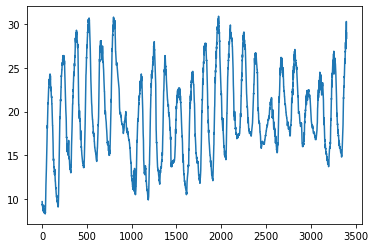

In [46]:
plt.plot(train['X00'][:3400])

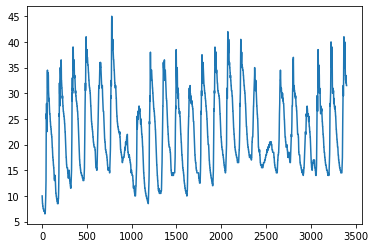

In [71]:
plt.plot(train['Y06'][:3400])

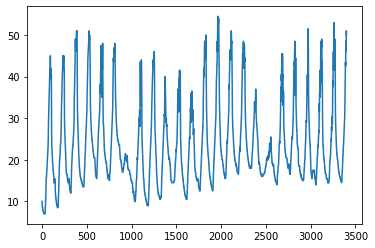

In [75]:
plt.plot(train['Y08'][:3400])

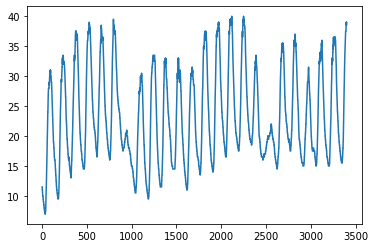

In [43]:
plt.plot(train['Y01'][:3400])

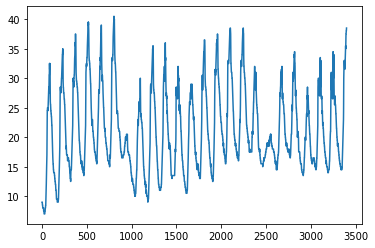

In [45]:
plt.plot(train['Y15'][:3400])

In [193]:
train_df2

,day,hour,X00,X07,X28,X31,X32,meanday_X00,maxday_X00,minday_X00,...,rangeday_X31,tmp_shift_+1_day_X31,tmp_shift_-1_day_X31,meanday_X32,maxday_X32,minday_X32,stdday_X32,rangeday_X32,tmp_shift_+1_day_X32,tmp_shift_-1_day_X32
id,,,,,,,,,,,,,,,,,,,,,
4320,30,0,19.3,20.8,21.0,18.0,18.7,22.396528,28.5,16.5,...,12.5,18.1,17.7,23.056250,29.0,18.7,3.214841,10.3,18.5,19.0
4321,30,0,19.0,20.6,20.7,17.7,19.0,22.396528,28.5,16.5,...,12.5,18.0,17.4,23.056250,29.0,18.7,3.214841,10.3,18.7,19.2
4322,30,0,19.1,20.5,20.7,17.4,19.2,22.396528,28.5,16.5,...,12.5,17.7,17.5,23.056250,29.0,18.7,3.214841,10.3,19.0,19.3
4323,30,0,19.2,20.5,20.6,17.5,19.3,22.396528,28.5,16.5,...,12.5,17.4,17.4,23.056250,29.0,18.7,3.214841,10.3,19.2,19.5
4324,30,0,19.2,20.5,20.5,17.4,19.5,22.396528,28.5,16.5,...,12.5,17.5,17.4,23.056250,29.0,18.7,3.214841,10.3,19.3,19.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,32,23,19.9,21.7,23.8,17.7,19.1,22.818750,28.1,18.6,...,11.7,17.7,17.7,21.978472,29.5,16.9,3.631509,12.6,19.5,19.2
4748,32,23,19.9,21.6,23.6,17.7,19.2,22.818750,28.1,18.6,...,11.7,17.7,17.8,21.978472,29.5,16.9,3.631509,12.6,19.1,19.2
4749,32,23,19.7,21.4,23.6,17.8,19.2,22.818750,28.1,18.6,...,11.7,17.7,17.7,21.978472,29.5,16.9,3.631509,12.6,19.2,19.3


In [195]:
train

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,1007.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,1007.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,1007.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


In [200]:
train.iloc[-432:,:]

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,
4320,19.3,987.7,0.9,2.2,0.0,1007.7,988.0,20.8,1007.8,1007.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4321,19.0,987.6,1.9,2.2,0.0,1007.7,988.0,20.6,1007.8,1007.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4322,19.1,987.6,2.0,1.4,0.0,1007.8,988.1,20.5,1007.9,1007.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4323,19.2,987.7,1.8,1.5,0.0,1007.9,988.1,20.5,1007.9,1007.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
4324,19.2,987.8,1.4,1.4,0.0,1007.9,988.1,20.5,1007.8,1007.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,1007.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,1007.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,1007.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


array([21.28100308, 20.99073303, 20.36235267, 20.15790796, 20.24603867,
       20.23689931, 20.03398504, 19.87401352, 20.24928153, 20.27605749,
       20.27187659, 20.31056827, 20.29559921, 20.28501009, 20.31055143,
       20.32675386, 20.28459536, 20.16000114, 20.1241737 , 19.95611598,
       19.87769333, 19.75524612, 19.76106536, 19.83710752, 19.82715322,
       19.82068007, 19.82584616, 19.82993421, 19.54058279, 19.39388285,
       19.25962637, 19.15140894, 19.16185413, 19.10892424, 19.03415808,
       18.9063365 , 18.92227484, 18.98261863, 19.05007407, 19.03944806,
       19.088576  , 19.02331838, 19.39906763, 19.2573348 , 19.42519538,
       19.57408338, 19.99878843, 20.29702345, 20.19756939, 20.52133605,
       21.41354553, 21.14817256, 21.04518023, 21.23918436, 21.54481308,
       21.44903407, 21.14964414, 21.43301611, 21.74285591, 21.93696606,
       21.85773528, 21.93720299, 21.91249816, 22.10423914, 22.301827  ,
       22.63810726, 22.90754791, 23.58060192, 23.47576359, 22.99

In [181]:
import numpy as np 
import pandas as pd
from sklearn import *
import lightgbm as lgb

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.shape, test.shape

((4752, 60), (11520, 41))

In [182]:
def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = df.index  - (df.batch * 50_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) / 2
    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan

    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    return df

train = features(train)
test = features(test)

KeyError: 'time'

In [ ]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]
x1, x2, y1, y2 = model_selection.train_test_split(train[col], train['open_channels'], test_size=0.3, random_state=7)
del train

def lgb_Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = metrics.cohen_kappa_score(labels, preds, weights = 'quadratic')
    return ('KaggleMetric', score, True)
 
params = {'learning_rate': 0.8, 'max_depth': 7, 'num_leaves':2**7+1, 'metric': 'rmse', 'random_state': 7, 'n_jobs':-1} 
model = lgb.train(params, lgb.Dataset(x1, y1), 2000,  lgb.Dataset(x2, y2), verbose_eval=50, early_stopping_rounds=50, feval=lgb_Metric)
preds = model.predict(test[col], num_iteration=model.best_iteration)
test['open_channels'] = np.round(np.clip(preds, 0, 10)).astype(int)

test[['time','open_channels']].to_csv('submission.csv', index=False, float_format='%.4f')

Training until validation scores don't improve for 50 rounds


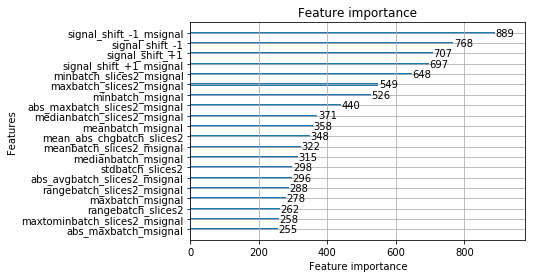

In [4]:
lgb.plot_importance(model,importance_type='split', max_num_features=20)